In [7]:
from __future__ import print_function
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # warning level
os.environ["CUDA_VISIBLE_DEVICES"] = "0" # use GPU 0
import numpy as np
import tensorflow as tf
from tensorflow.contrib import rnn
import sys
from math import ceil

This is architecture of model-beta. Here PCA is performed on X(cascaded x1 and x2 from model-alpha) which reduce the dimension of data but keeping good features of data. After this it is passed to LSTM and then to FC neural network which give predictions
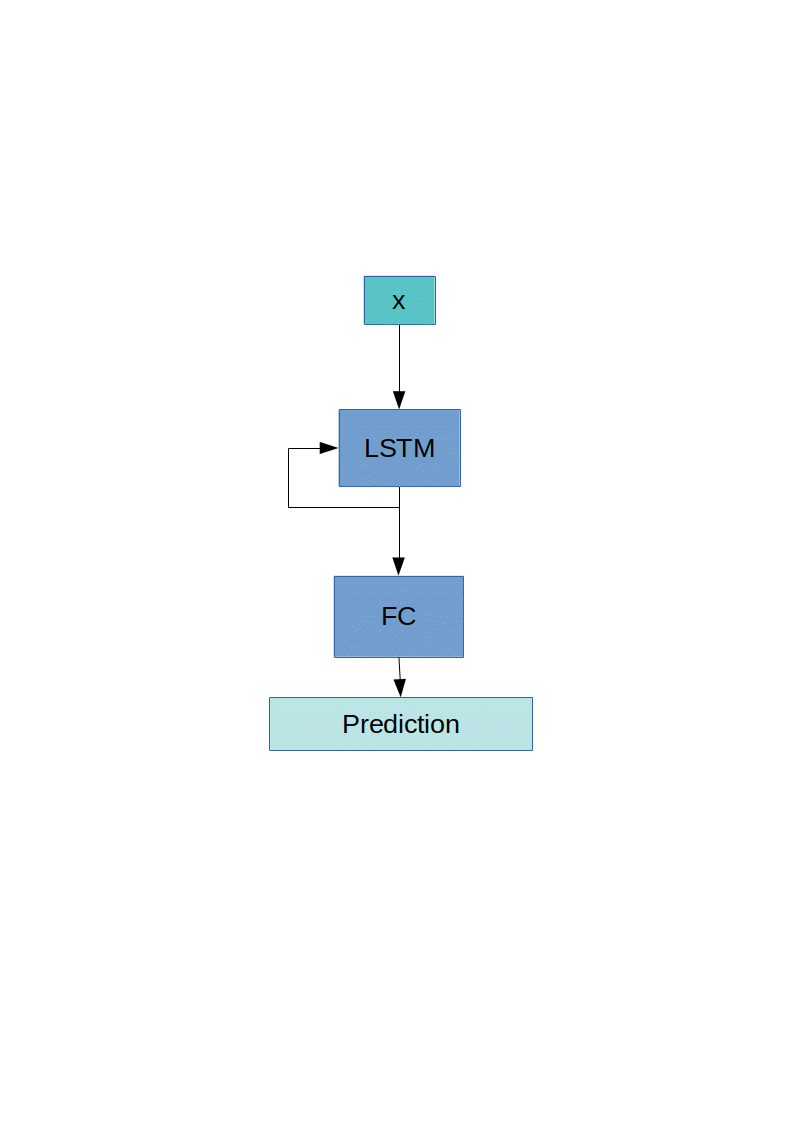

In [3]:
def buildGraph():
    global x
    global y
    global weights
    global biases
    global cost
    global optimizer
    global correct_pred
    global accuracy
    global pred
    global init
    global saver

    with tf.device('/gpu:0'):

        # reset Graph
        tf.reset_default_graph()

        # tf Graph input
        x = tf.placeholder("float", [None, n_steps, n_input], name='x')
        y = tf.placeholder("float", [None, n_classes], name='y')

        # Prepare data shape to match `rnn` function requirements
        # Current data input shape: (batch_size, n_steps, n_input)
        # Required shape: 'n_steps' tensors list of shape (batch_size, n_input)
        # Permuting batch_size and n_steps
        x1 = tf.transpose(x, [1, 0, 2])
        # Reshaping to (n_steps*batch_size, n_input)
        x1 = tf.reshape(x1, [-1, n_input])
        # Split to get a list of 'n_steps' tensors of shape (batch_size, n_input)
        x1 = tf.split(x1, n_steps, 0)

        # Define weights
        weights = tf.Variable(tf.random_normal([n_hidden, n_classes]))
        biases = tf.Variable(tf.random_normal([n_classes]))

        # Define a lstm cell with tensorflow
        lstm_cell = rnn.LSTMCell(n_hidden, use_peepholes=False)

        # Get lstm cell output
        outputs, states = rnn.static_rnn(lstm_cell, x1, dtype=tf.float32)

        # Linear activation, using rnn inner loop last output
        tmp1 = tf.matmul(outputs[-1], weights)
        pred = tf.add(tmp1, biases, name='pred')

        # Define loss and optimizer
        cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

        # Evaluate model
        correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
        accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='Accuracy')

        # Initializing the variables
        init = tf.global_variables_initializer()

        # write the model
        #writer = tf.summary.FileWriter(logs_path, graph=tf.get_default_graph())

        # 'Saver' op to save and restore all the variables
        saver = tf.train.Saver()

    return


In [4]:
def runModel(ID):
    global sess
    global predY
    global acc
    global loss
    global losses
    global acces
    global testAccs
    global trainX
    global trainYcat

    # set configs
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True # usw memory of GPUs more efficiently

    # Launch the graph
    with tf.Session(config=config) as sess:
        sess.run(init)

        for curr_epoch in range(num_epochs):
            for batch in range(num_batches_per_epoch):

                # Preparing required batch
                batch_x = trainX[batch*batch_size:(batch+1)*batch_size,:,:]
                batch_y = trainYcat[batch*batch_size:(batch+1)*batch_size,:] 

                # Reshape data to get 28 seq of 28 elements
                batch_x = batch_x.reshape((batch_size, n_steps, n_input))

                # Run optimization op (backprop)
                sess.run(optimizer, feed_dict={x: batch_x, y: batch_y})

                # Calculate accuracy of last epoch batch and batch loss
                acc, loss = sess.run([accuracy, cost], feed_dict={x: batch_x, y: batch_y})

            #losses.append(loss)
            #acces.append(acc)

        # save the prediction of train datas
        predY = sess.run(pred, feed_dict={x: trainX, y: trainYcat})
        directory = os.path.dirname(predsPath)
        try:
            os.stat(directory)
        except:
            os.mkdir(directory)
        np.save( predsPath + ID + '_predY.npy', predY)

        # Save model weights to disk
        directory = os.path.dirname(model_path)
        try:
            os.stat(directory)
        except:
            os.mkdir(directory)
        model_path_ID = model_path + ID + '/'
        directory = os.path.dirname(model_path_ID)
        try:
            os.stat(directory)
        except:
            os.mkdir(directory)
        del directory
        save_path = saver.save(sess, model_path_ID+'model.ckpt')
        print("ModelB of %s was saved" % str(ID+'_'+str(run)))

    return


In [5]:
def loadTrainVars(ID):
    global num_batches_per_epoch
    global trainX
    global trainYcat
    global n_input

    # load train variables
    vars_path_ID = vars_path + ID + '/'
    trainX = np.load(vars_path_ID+'trainX.npy')
    trainYcat = np.load(vars_path_ID+'trainYcat.npy')

    # make some general numbers
    num_examples = trainX.shape[0]
    num_batches_per_epoch = int(num_examples//batch_size)
    n_input = (trainX.shape[2]//n_steps)
    trainX = trainX.reshape((trainX.shape[0], n_steps, n_input))

    return


In [6]:
n_classes = 7
num_epochs = 100
num_layers = 1
batch_size = 100
learning_rate = 1e-3
ret = 0
n_hidden = 50
n_steps = 5

# data paths
vars_path = '../Data/BB/'
models_path = '../models/'
logs_path = './Logs/'
#IDs = ['100','101','103','105','106','108','109','111','112','113','114','115','116','117','118','119','121','122','123','124','200', '201', '202', '203', '205', '207', '208', '209', '210', '212', '213', '214', '215', '219', '220', '221', '222', '223', '228', '230', '231', '232', '233', '234'] # all records
#IDs = ['200', '201', '202', '203', '205', '207', '208', '209', '210', '212', '213', '214', '215', '219', '220', '221', '222', '223', '228', '230', '231', '232', '233', '234']
IDs = ['100','101','103','105','106','108','109','200', '201', '202', '203', '205', '207', '208', '209', '210', '212', '213', '214', '215'] # all records
runs = np.random.permutation(np.arange(1, 10))#ret#['_1', '_2', '_3', ..., '_50']

In [8]:
for ID in IDs:
    loadTrainVars(ID) #load variables

    for run in runs:
        # path of saving models and their results
        model_path = models_path + 'modelsB_' + str(run) + '_' + str(ret) + '/'
        predsPath = '../preds/trainB_outs_' + str(run) + '_' + str(ret) + '/'
        buildGraph() #make the graph
        runModel(ID) #train the model with train data


Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

ModelB of 100_4 was saved
ModelB of 100_7 was saved
ModelB of 100_5 was saved
ModelB of 100_8 was saved
ModelB of 100_3 was saved
ModelB of 100_1 was saved
ModelB of 100_2 was saved
ModelB of 100_6 was saved
ModelB of 100_9 was saved
ModelB of 101_4 was saved
ModelB of 101_7 was saved
ModelB of 101_5 was saved
ModelB of 101_8 was saved
ModelB of 101_3 was saved
ModelB of 101_1 was saved
ModelB of 101_2 was saved
ModelB of 101_6 was saved
ModelB of 101_9 was saved
ModelB of 103_4 was saved
ModelB of 103_7 was saved
ModelB of 103_5 was saved
ModelB of 103_8 was saved
ModelB of 103_3 was saved
ModelB of 103_1 was saved
ModelB of 103_2 was saved
ModelB of 103_6 was saved
ModelB of 103_9 was saved
ModelB of 105_4 was saved
ModelB of 105_7 was saved
ModelB of 105_5 was saved
ModelB of 105_8 was saved
Mod